## 1 
Suppose that we model observed data $y$ with the joint probability density function $f(y|\theta)$.

### (a) 
Describe the assumptions about $\theta$ from both the *frequentist* and *Bayesian* standpoint.  
My answer:  
- frequentist: $\theta$s are fixed unknown constants. Frequentists estimate them and look at the sampling distribution of the estimates.  
- Bayesian: $\theta$s are random variables, meaning they are events that have a corresponding probability distribution.

### (b)
Suppose that we would like to determine whether or not $\theta=0$. Describe how to go about this from both a *frequentist* and *Bayesian* standpoint.

My answer:
- frequentist: do a hypothesis test with $H_0:\ \theta=0$, and use a p-value to test if $\theta$ is significantly different from $0$. 
- Bayesians have posterior distribution of $\theta$ so they can have probability of $\theta$.

### (c)
When do frequentist and Bayesian inference provide the same conclusions about $\theta$ from your inferential tasks described in (b)?

My answer:
- When sample size is very large, frequentist and Bayesian inference provide the same conclusions about $\theta$.

### (d)
What is the difference between a 95% confidence interval and a 95% credible interval for $\theta$?

## 2

### (a) 
- rejection sampling then estimate expectation. 

### (b)
- Use importance sampling method

### (c)
- Use importance sampling method

### (d)
- Use rejection sampling method to simulate from $p(\theta|y)$.

## 3 Creating animations with MCMC

In [27]:
import numpy as np
import imcmc

### (a)

Sequential sampling (1 chains in 1 job)
Metropolis: [image]
100%|██████████| 1500/1500 [00:00<00:00, 9508.72it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


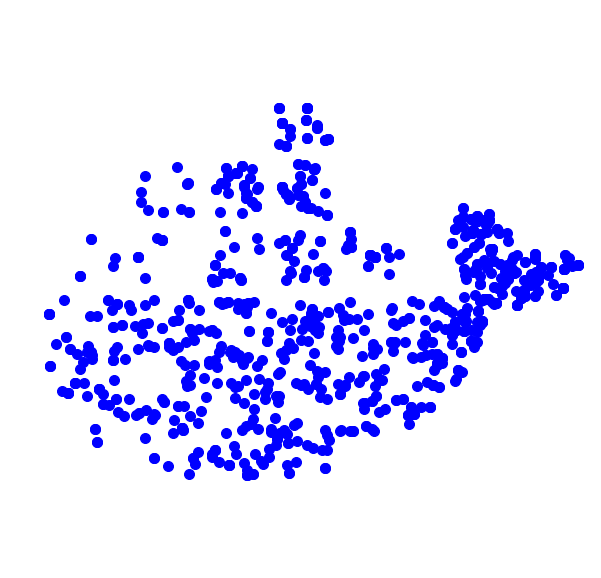

In [28]:
# Rerun this cell until the image looks good
np.random.seed(8)
image = imcmc.load_image('docker.png', 'L')
trace = imcmc.sample_grayscale(image, samples=1000, tune=500, nchains=1, threshold=0.1)
imcmc.plot_multitrace(trace, image, marker='o', markersize=10, colors=['#0000FF','#0000FF', '#FFFF00'], alpha=1);

/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py:1218: UserWarning: MovieWriter imagemagick unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


'example.html'

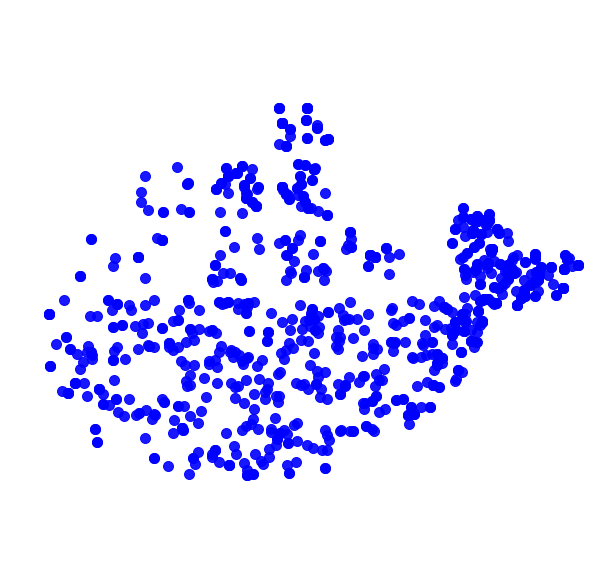

In [30]:
imcmc.make_gif(trace, image, dpi=40, marker='o', markersize=10,
               colors=['#0000FF', '#FFFF00'], alpha=0.9, 
               filename='example.html')

## 4

In [143]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
import scipy.stats as stats
from IPython.core.pylabtools import figsize
figsize(12,4)

#these two quantities are unknown to us.
true_alpha1 = 215/600  #proportion of people supported Trump before presidential debate; use sample mean to initialize
true_alpha2 = 280/600  #proportion after

N = 600  # sample size

# generate observations
observations1 = stats.bernoulli.rvs(true_alpha1, size=N)
observations2 = stats.bernoulli.rvs(true_alpha2, size=N)
print("Obs from before presidential debate: ", observations1[:30], "...")
print("Obs from after presidential debate: ", observations2[:30], "...")

Obs from before presidential debate:  [1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 1 0 0] ...
Obs from after presidential debate:  [1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0] ...


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [144]:
print(np.mean(observations1))
print(np.mean(observations2))

0.37666666666666665
0.4483333333333333


In [145]:
# set up the pymc3 model. Assume Uniform priros for alpha1 and alpha2
with pm.Model() as model:
    alpha1 = pm.Uniform('alpha1', lower=0, upper=1)
    alpha2 = pm.Uniform('alpha2', lower=0, upper=1)
    
    # define the deterministic delta function. This is our unknown of interest
    delta = pm.Deterministic('delta', alpha2-alpha1)
    
    # set of obervations, in this case we have two observation datasets
    obs1 = pm.Bernoulli('obs1', alpha1, observed=observations1)
    obs2 = pm.Bernoulli('obs2', alpha2, observed=observations2)
    
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace = trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha2]
>Metropolis: [alpha1]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:09<00:00, 9110.74draws/s] 
The number of effective samples is smaller than 25% for some parameters.


In [7]:
alpha1_samples = burned_trace['alpha1']
alpha2_samples = burned_trace['alpha2']
delta_samples = burned_trace['delta']

In [37]:
alpha1_samples

array([0.36812656, 0.36812656, 0.36812656, ..., 0.33854717, 0.42460875,
       0.42460875])

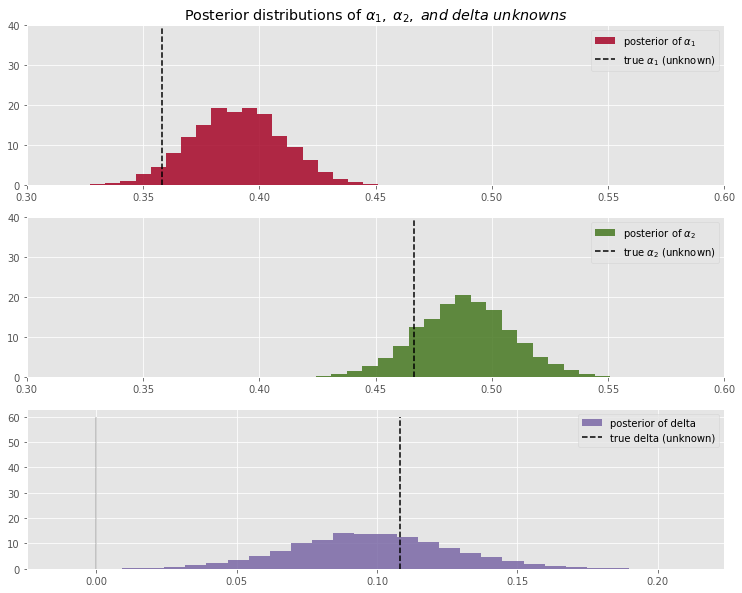

In [42]:
figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0.3, .6)
plt.ylim(0, 40)
plt.hist(alpha1_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label=r"posterior of $\alpha_1$", color="#A60628", normed=True)
plt.vlines(true_alpha1, 0, 80, linestyle="--", label=r"true $\alpha_1$ (unknown)")
plt.legend(loc="upper right")
plt.title(r"""Posterior distributions of $\alpha_1,\;\alpha_2,\;and\ delta\ unknowns$""")

ax = plt.subplot(312)

plt.xlim(0.3, .6)
plt.ylim(0, 40)
plt.hist(alpha2_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label=r"posterior of $\alpha_2$", color="#467821", normed=True)
plt.vlines(true_alpha2, 0, 80, linestyle="--", label=r"true $\alpha_2$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_alpha2 - true_alpha1, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

delta distribution is entirely to the right of zero, so 100% that there was a shift away from Clinton after the debate

In [44]:
np.mean(delta_samples>0)

0.9997105263157895

## 5

In [ ]:
import scipy.stats as st

def p(x):
    

### (a) What proposal function would you use to simulate from p(x)?
- uniform distribution $x\sim U(0, 2)$

### (b) What M would you use based on your proposal function?
- $M = max(\frac{P(x)}{Q(x)})$ for all x, in this case M=3

### (c)


In [140]:
from scipy.stats import uniform
import matplotlib.pyplot as plt

# The multiplication constant to make probability estimation fit
M = 2
# Number of samples to draw from the probability estimation function
N = 1000

# the target probability density function
#cond1 = [True if (j>0. and j<1.) else False for j in x]
#cond2 = [True if (j>1. and j<2.) else False for j in x]
#p = lambda x: np.piecewise(x, [x<=0, x<=1, x<=2, x>2], [0, lambda x: x, lambda x: -x+2, 0])
def p(x):
    if x <=0 or x>=2:
        return 0
    elif x < 1: 
        return x
    else:
        return -x+2

# the proposal probability density function
q = lambda x: uniform.pdf(x, 0, scale=2)

# a number of samples, drawn from the proposal density function
x_samples = M*np.random.uniform(-0.5, 2.5, (N,))

# a number of samples in the interval [-0.5, 2.5]
u = np.random.uniform(-0.5, 2.5, (N,))

samples = [(x_samples[i], u[i] * M * q(x_samples[i])) for i in range(N) if u[i] < p(x_samples[i]) / (M * q(x_samples[i]))]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


(0, 1.5)

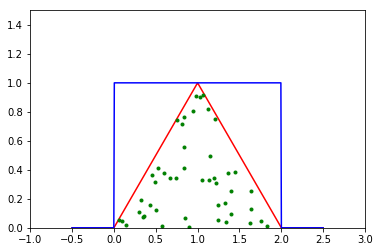

In [141]:
fig, ax = plt.subplots(1, 1)

# The x coordinates
x = np.linspace(-0.5, 2.5, 500)
p_y = [p(i) for i in x]

# The target probability function
ax.plot(x, p_y, 'r-', label='$f(x)$')

# The approximated probability density function
ax.plot(x, M * q(x), 'b-', label='$M \cdot g(x)$')

ax.plot([sample[0] for sample in samples], [sample[1] for sample in samples], 'g.', label='Samples')

# Set the window size
axes = plt.gca()
axes.set_xlim([-1, 3])
axes.set_ylim([0, 1.5])